# Object Detection

Impletement Yolo v1-like architecture

In [1]:
!head ../dataset_import_files/salads.csv

gs://cloud-ml-data/img/openimage/103/279324025_3e74a32a84_o.jpg,Baked Goods,0.005743,0.084985,,,0.567511,0.735736,,
gs://cloud-ml-data/img/openimage/103/279324025_3e74a32a84_o.jpg,Salad,0.402759,0.310473,,,1.000000,0.982695,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.000000,0.000000,,,0.054865,0.480665,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.041131,0.401678,,,0.318230,0.785916,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.116263,0.065161,,,0.451528,0.286489,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.557359,0.411551,,,0.988760,0.731613,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.562206,0.059401,,,0.876467,0.260982,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.567861,0.000161,,,0.699543,0.077502,,
gs://cloud-ml-data/img/openimage/1064/3167707458_7b2eebed9e_o.jpg,Cheese,0.916052,0.085569,,,1.0

In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

In [3]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
pip install . --user --quiet
pip install --user --quiet protobuf==3.20
pip install --user numpy --force-reinstall

  Using cached numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (15.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.9.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.55.0 which is incompatible.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 7.0.0 which is incompatible.
google-cloud-recommendations-ai 0.2.0 requires google-api-core[grpc]<2.0.0dev,>=1.22.2, but you have google-api-core 2.8.1 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which is incompatible.
tensorboard 2.9.1 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.0 which i

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

## Data Loader

In [5]:
df = pd.read_csv("../dataset_import_files/salads.csv")
CLASSES = df.iloc[:, 1].unique()

In [6]:
def parse_csv(row):
    row = tf.strings.split(row, ",")
    path = row[0]
    label = row[1]
    sbox = tf.gather(row, [3, 2, 7, 6])
    bbox = tf.strings.to_number(sbox)
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)
    # img = tf.cast(img, tf.float32)
    return path, img, label, bbox


data = tf.data.TextLineDataset("../dataset_import_files/salads.csv").map(
    parse_csv
)

2022-09-30 07:16:39.051910: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 07:16:39.064417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 07:16:39.066226: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-30 07:16:39.069234: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
for path, img, label, bbox in data.take(1):
    print(path)
    print(img)
    print(label)
    print(bbox)

tf.Tensor(b'gs://cloud-ml-data/img/openimage/103/279324025_3e74a32a84_o.jpg', shape=(), dtype=string)
tf.Tensor(
[[[ 96 100  75]
  [ 95  99  74]
  [ 95  97  73]
  ...
  [ 85  90  86]
  [ 87  91  90]
  [ 88  92  91]]

 [[ 97  99  77]
  [ 97  99  77]
  [ 96  98  74]
  ...
  [ 86  91  87]
  [ 88  93  89]
  [ 89  94  90]]

 [[ 98 100  79]
  [ 98 100  79]
  [ 99  98  78]
  ...
  [ 88  91  84]
  [ 89  91  86]
  [ 90  92  87]]

 ...

 [[ 19  16   7]
  [ 20  17   8]
  [ 20  17   8]
  ...
  [ 41  41  41]
  [ 41  43  42]
  [ 45  46  48]]

 [[ 17  17   5]
  [ 18  18   6]
  [ 17  19   6]
  ...
  [ 40  42  41]
  [ 42  44  43]
  [ 45  46  48]]

 [[ 15  17   3]
  [ 16  18   4]
  [ 16  18   5]
  ...
  [ 40  42  39]
  [ 42  44  43]
  [ 45  47  46]]], shape=(1200, 1600, 3), dtype=uint8)
tf.Tensor(b'Baked Goods', shape=(), dtype=string)
tf.Tensor([0.084985 0.005743 0.735736 0.567511], shape=(4,), dtype=float32)


In [8]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):

    image_np_with_annotations = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.3,
        line_thickness=20)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

In [9]:
num_classes = len(CLASSES)
class_preprec = tf.keras.layers.StringLookup(vocabulary=CLASSES)
category_index = {i:{'id':i, 'name': class_name} for i, class_name in enumerate(class_preprec.get_vocabulary()) if class_name != '[UNK]'}

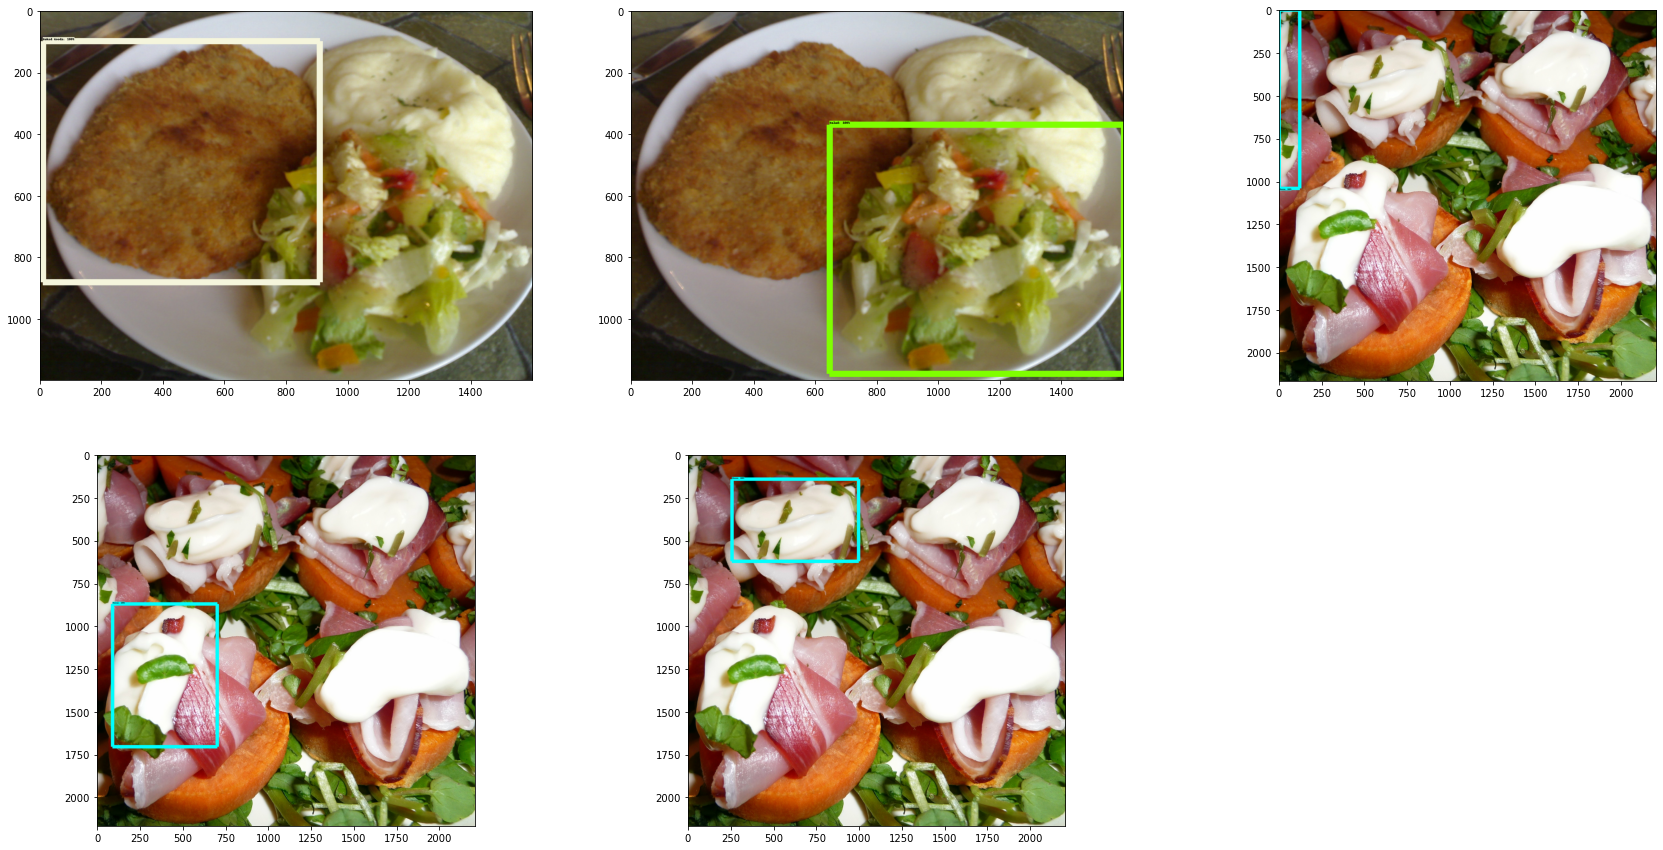

In [10]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))    
for idx, (path, img, label, bbox)  in enumerate(data.take(5)):
    plt.subplot(2, 3, idx+1)
    plot_detections(
        img.numpy(),
        tf.expand_dims(bbox, 0).numpy(),
        class_preprec(tf.expand_dims(label, 0)).numpy(),
        [1],
        category_index,
  )

plt.show()

## Retrieve pretrained weights

In [22]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2022-09-30 07:20:08--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 108.177.111.128, 2607:f8b0:4001:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|108.177.111.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.24’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   334MB/s    in 0.7s    

2022-09-30 07:20:09 (334 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.24’ saved [244817203/244817203]

mv: cannot move 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint' to 'models/research/object_detection/test_data/checkpoint': Directory not empty


In [23]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)

ckpt = tf.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


## Fine Tuning

In [24]:
# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

In [25]:
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):

    def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list,
                    batch_size):

        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            prediction_dict = model.predict(image_tensors, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss

    return train_step_fn

In [26]:
learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

NUM_SAMPLES = len(df)
BATCH_SIZE = 1
EPOCHS = 5

print('Start fine-tuning!', flush=True)

def _preprocess(path, img, label, bbox):
    label = tf.one_hot(class_preprec(label), num_classes)

    img = tf.expand_dims(img, axis=0)
    img = tf.cast(img, tf.float32)
    img = detection_model.preprocess(img)[0]
    img = tf.squeeze(img, axis=0)
    return path, img, label, bbox

for idx, (path, img, label, bbox) in enumerate(data.map(_preprocess).batch(BATCH_SIZE).repeat(EPOCHS)):
    total_loss = train_step_fn(img, [bbox], [label], batch_size)

    if idx % 50 == 0:
        print('batch ' + str(idx) + ' of ' + str(NUM_SAMPLES * EPOCHS)
        + ', loss=' +  str(total_loss.numpy()), flush=True)
    
print('Done fine-tuning!')

Start fine-tuning!
batch 0 of 8780, loss=0.11478664
batch 50 of 8780, loss=0.95184064
batch 100 of 8780, loss=0.901822
batch 150 of 8780, loss=1.1554741
batch 200 of 8780, loss=1.2753994
batch 250 of 8780, loss=0.99383515
batch 300 of 8780, loss=1.1207224
batch 350 of 8780, loss=1.8563399
batch 400 of 8780, loss=2.4603527
batch 450 of 8780, loss=1.4201896
batch 500 of 8780, loss=2.5439136
batch 550 of 8780, loss=0.57037586
batch 600 of 8780, loss=1.3268433
batch 650 of 8780, loss=2.0883677
batch 700 of 8780, loss=1.1924778
batch 750 of 8780, loss=2.3832827
batch 800 of 8780, loss=1.1260245
batch 850 of 8780, loss=2.1338797
batch 900 of 8780, loss=0.9332441
batch 950 of 8780, loss=0.8408515
batch 1000 of 8780, loss=0.49486396
batch 1050 of 8780, loss=0.84233445
batch 1100 of 8780, loss=0.90673935
batch 1150 of 8780, loss=0.67652756
batch 1200 of 8780, loss=1.2585446
batch 1250 of 8780, loss=2.626985
batch 1300 of 8780, loss=2.3284426
batch 1350 of 8780, loss=1.1988821
batch 1400 of 8780

KeyboardInterrupt: 

## Detection

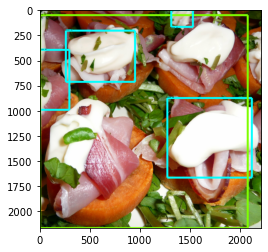

In [36]:
test_image_index = 1
image_path = df.iloc[:,0].unique()[test_image_index]

img = tf.io.read_file(image_path)
img = tf.io.decode_jpeg(img, channels=3)

img_float = tf.cast(img, tf.float32)
img_tensor = tf.expand_dims(img_float, axis=0)

preprocessed_image, shapes = detection_model.preprocess(img_tensor)
prediction_dict = detection_model.predict(preprocessed_image, shapes)
detections = detection_model.postprocess(prediction_dict, shapes)

plot_detections(
  img.numpy(),
  detections['detection_boxes'][0].numpy(),
  detections['detection_classes'][0].numpy().astype(np.uint32),
  detections['detection_scores'][0].numpy(),
  category_index, figsize=(15, 20))